In [1]:
import pickle
import pandas as pd
import torch
import scipy.sparse
#import transformers
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import precision_score, recall_score, average_precision_score, precision_recall_curve, roc_auc_score, roc_curve, auc

from transformers_custom import BertForMaskedLM, BertConfig, AdamW, get_scheduler, BertForTokenClassification, BertTokenizerFast
import matplotlib.pyplot as plt


Matplotlib created a temporary config/cache directory at /tmp/matplotlib-g6ygj2ji because the default path (/gpfs/home/nsj244/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


### Pretrain Data Load

In [8]:
def data_load():
    
    xallFile = "/gpfs/data/razavianlab/capstone/2021_ehr/preprocessed_xall_with_outcome.npz"
    data = scipy.sparse.load_npz(xallFile)

    outcomes = (data[:, -1])
    outcomes = outcomes.toarray()

    with open('mapping_dict_LARGE.pkl', 'rb') as f:
        mapping_dict = pickle.load(f)

    with open('final_list_modified_LARGE.pkl', 'rb') as f:
        final_list_modified = pickle.load(f)

    with open('study_indexes_LARGE.pkl', 'rb') as f:
        study_indexes = pickle.load(f)

    # Pretrain Model
    BertModel = torch.load("model.pkl")
    
    del data
    
    return outcomes, mapping_dict, final_list_modified, study_indexes, BertModel

In [9]:
outcomes, mapping_dict, final_list_modified, study_indexes, BertModel = data_load()

### Downsampling Functions

In [10]:
def train_downsample(NON_DEM_TO_DEM_TRAIN_RATIO, PRECENTAGE_DEMENTIA_TRAINING, dementia_outcomes, study_indexes, final_list_modified):
  
    train_inputs = {}

    # getting first 10% of len(dementia_outcomes == 1)
    max_train_dementia_index = int(len(np.where(dementia_outcomes == 1)[0])*PRECENTAGE_DEMENTIA_TRAINING)
    print("Amount of training dementia cases:", max_train_dementia_index)
    # getting ratio multiple of max_train_dementia_index for (dementia_outcomes == 0)
    max_train_NONdementia_index = NON_DEM_TO_DEM_TRAIN_RATIO * max_train_dementia_index
    print("Amount of training non dementia cases:", max_train_NONdementia_index)

    # concatenating indexes of dementia and non dementia studies chosen for training
    train_dem_inds = np.where(dementia_outcomes == 1)[0][:max_train_dementia_index]
    train_NONdem_inds = np.where(dementia_outcomes == 0)[0][:max_train_NONdementia_index]
    train_inds = np.concatenate((train_dem_inds,train_NONdem_inds), axis=0)

    # randomly shuffling indecies such that 0s and 1s mixed for training
    random.shuffle(train_inds)
    train_inputs["labels"] = dementia_outcomes[train_inds]
    train_inputs["input_ids"] = list(zip(np.array(study_indexes,dtype=object)[train_inds],np.array(final_list_modified,dtype=object)[train_inds]))

    print(round(len(train_inds)/len(dementia_outcomes),4), "of overall data used for train")

    return train_inputs, train_inds

def val_test_split(train_inds, study_indexes, dementia_outcomes, final_list_modified):
  
    val_inputs = {}
    test_inputs = {}

    train_inds.sort()
    study_trains = np.array(study_indexes)[train_inds]
    study_trains_max = study_trains[len(study_trains)-1]

    # finding last study used in training
    final_train_ind = 0
    for index, i in enumerate(study_indexes):
        if i == study_trains_max:
            final_train_ind = index
    

    # only considering studies that are after last train study (chance of patient overlap if including data prior to last train study)
    post_train_study_indexes = study_indexes[(final_train_ind+1):]
    post_train_final_list = final_list_modified[(final_train_ind+1):]
    post_train_dementia = dementia_outcomes[(final_train_ind+1):]

    # splitting validation and test equally
    split = len(post_train_dementia)//2

    # inputs ids
    val_inputs["input_ids"] = list(zip(post_train_study_indexes[:split],post_train_final_list[:split]))
    test_inputs["input_ids"] = list(zip(post_train_study_indexes[split:],post_train_final_list[split:]))

    # labels
    val_inputs["labels"] = post_train_dementia[:split]
    test_inputs["labels"] = post_train_dementia[split:]

    print("Amount of val cases:", len(val_inputs["labels"]), "which is ", round(len(val_inputs["labels"])/len(study_indexes),4),"of the dataset")
    print("Amount of test cases:", len(test_inputs["labels"]), "which is ", round(len(test_inputs["labels"])/len(study_indexes),4) ,"of the dataset")

    return val_inputs, test_inputs



In [14]:
import random
random.seed(10)

dementia_outcomes = []

study_indexes.sort()

# grabbing only indexes used in pretrain
for index in study_indexes:
    dementia_outcomes.append(outcomes[index])
dementia_outcomes = np.array(dementia_outcomes)

# ratio of downsample
NON_DEM_TO_DEM_TRAIN_RATIO = 3
PRECENTAGE_DEMENTIA_TRAINING = .7

train_inputs, train_inds = train_downsample(NON_DEM_TO_DEM_TRAIN_RATIO, PRECENTAGE_DEMENTIA_TRAINING, dementia_outcomes, study_indexes, final_list_modified)
val_inputs, test_inputs = val_test_split(train_inds, study_indexes, dementia_outcomes, final_list_modified)

Amount of training dementia cases: 13072
Amount of training non dementia cases: 39216
0.0291 of overall data used for train
Amount of val cases: 265121 which is  0.1473 of the dataset
Amount of test cases: 265122 which is  0.1473 of the dataset


In [15]:
print(len(train_inputs["input_ids"]), len(val_inputs["input_ids"]), len(test_inputs["input_ids"]))

(52288, 265121, 265122)

### TEST Downsample 

In [16]:
#test_inds = np.where(test_inputs["labels"] == 0)[0]

test_dem = np.where(test_inputs["labels"] == 1)[0]
test_dem_length = len(test_dem)
test_n_inds = np.where(test_inputs["labels"] == 0)[0]
test_non_dem_inds = np.random.choice(test_n_inds,size=test_dem_length*3, replace=False)

total_inds = list(test_non_dem_inds)
print(len(total_inds))
total_inds.extend(list(test_dem))
print(len(total_inds))

random.shuffle(total_inds)

new_test = {"input_ids":[],"labels":[]}
for i in total_inds:
    chosen = test_inputs["input_ids"][i]
    new_test["input_ids"].append(chosen)
new_test["labels"] = test_inputs["labels"][total_inds]

len(new_test["input_ids"]),len(new_test["labels"])

8538
11384


(11384, 11384)

### Model

In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
#device = torch.device("cpu")
print("sending model to ", device)

sending model to  cuda


In [18]:
class FeedForwardNN(torch.nn.Module):
    def __init__(self, input_dim, output_dim, batch_size, mapping_size):
        super(FeedForwardNN, self).__init__()
        self.hidden_layer = 512
        self.linear1 = torch.nn.Linear(mapping_size*512, 2)
        self.batch_size = batch_size
        self.col_size = mapping_size*512

    def forward(self, x, BertModel):
        
        data = []
        lengths = []
        
        # padding data with 0s to end of every sequence
        for d in x:
            data.append(torch.tensor(d[1]))
            lengths.append(len(d[1]))
        padded_data = torch.stack([torch.cat([i, i.new_zeros(99 - i.size(0))], 0) for i in data]).to(torch.device("cuda"))
        
        # running BERT model on each sequence to get last hidden state
        last_hidden_state = BertModel(padded_data,output_hidden_states = True).hidden_states[-1]
        
        # initializing input
        nn_input = torch.zeros(self.batch_size, self.col_size, dtype=torch.float16)
        
        # putting hidden states into input by stacking them into a vector based on input position
        for i in range(batch_size):
            for j, index_col in enumerate(x[i][1]):
                nn_input[i][index_col*self.hidden_layer:index_col*self.hidden_layer
                         +self.hidden_layer] = last_hidden_state[i,j,:].cpu().detach()        
        
    
        outputs = self.linear1(nn_input.float().to(torch.device("cuda")))
        return outputs

In [49]:
batch_size = 24
epochs = 1
input_dim = 512
output_dim = 2
lr_rate = 1

BertModel = BertModel.to(torch.device("cuda"))
model = FeedForwardNN(input_dim, output_dim, batch_size, len(mapping_dict.keys())).to(torch.device("cuda"))
#model = torch.load("EPOCH_Model_1.pkl")

criterion = torch.nn.CrossEntropyLoss(weight = torch.tensor((1.0,3.0))).to(device) # computes softmax and then the cross entropy
softmax = torch.nn.Softmax(dim=1)

optimizer = torch.optim.Adam(model.parameters(), lr=lr_rate)

model.train()

### Training

In [51]:
train_labels = []
train_probs = []
train_losses = []

for epoch in range(epochs):

    print ('epoch', epoch)

    start = 0
    end = batch_size
    iteration = 0
    loss_avg = 0

    while end < len(train_inputs["input_ids"])//2: 

        x = train_inputs["input_ids"][start:end]
        outputs = model(x, BertModel)
        _, predicted = torch.max(outputs, 1)

        labels = torch.tensor([int(x) for x in train_inputs['labels'][start:end] ])
        train_y_prob = softmax(outputs)[:,1].detach()
        
        # appending results for metrics
        if epochs-epoch == 1:
            train_probs.append(train_y_prob)
            train_labels.append(labels)

        # step
        loss = criterion(outputs.to(device), labels.to(device))
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        loss_avg += loss.item()
            
        # model check
        if (iteration%100 == 0):
            if iteration == 0:
                print ("iteration:",iteration, " loss:",round(loss_avg,5))
            else:
                print ("iteration:",iteration, " loss:",round(loss_avg/100,5))
            loss_avg = 0
    

        iteration += 1
        start += batch_size
        end += batch_size
        torch.cuda.empty_cache()

epoch 0
iteration: 0  loss: 1273.83374
iteration: 100  loss: 4459.2947
iteration: 200  loss: 4521.82112
iteration: 300  loss: 3908.72773
iteration: 400  loss: 4220.25532
iteration: 500  loss: 3086.92785
iteration: 600  loss: 3457.19441
iteration: 700  loss: 3839.31682
iteration: 800  loss: 3566.30102
iteration: 900  loss: 3073.98002
iteration: 1000  loss: 4235.86212


In [71]:
def model_metrics(labs, probs):
    np_labs = torch.cat(labs).cpu().numpy()
    np_probs = torch.cat(probs).cpu().numpy()
    precision, recall, thresholds = precision_recall_curve(np_labs,np_probs)
    avg_precision = average_precision_score(np_labs,np_probs)
    fpr, tpr, thresholds = roc_curve(np_labs, np_probs)

    auc = roc_auc_score(np_labs,np_probs)
    
    print("AUC: ", auc)
    print("Avg Percision: ", avg_precision)
    
    return precision, recall, avg_precision, auc, fpr, tpr

In [73]:
precision, recall, avg_precision, auc,fpr, tpr = model_metrics(train_labels, train_probs)

In [74]:
avg_precision

0.2581507289506958

In [61]:
auc

0.5241931456951607

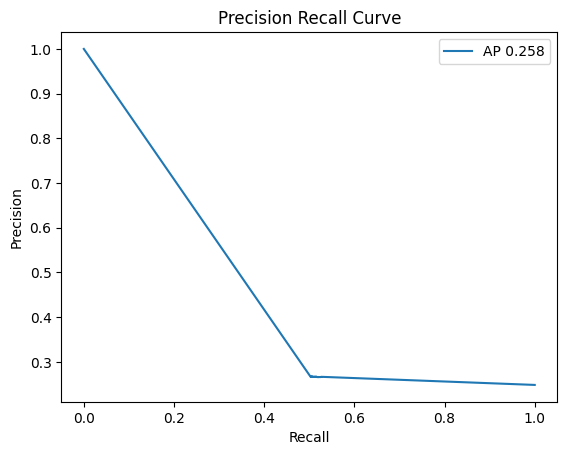

In [81]:
plt.plot(recall, precision, label='AP {}'.format(round(avg_precision, 3)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title('Precision Recall Curve')
#plt.axhline(y=0.25, color='r', linestyle='-',label='No Skill')# plt.ylim([0, 1.1])
plt.legend()
plt.show()

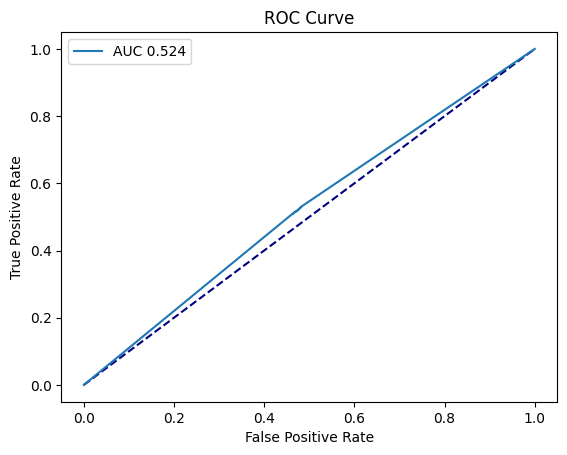

In [76]:
plt.plot([0, 1], [0, 1], color="navy", linestyle="--")
plt.plot(fpr, tpr, label='AUC {}'.format(round(auc, 3)))
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Validation

In [ ]:
val_batch = batch_size
v_start = 0
v_end = batch_size
val_iteration = 0
val_loss = 0
num_correct = 0
iterations = 0
val_probs = []
val_labels = []
with torch.no_grad():
    while v_end < len(val_inputs["input_ids"])//4: 
        val_iteration+=1
        outputs_val = model(val_inputs["input_ids"][v_start:v_end],BertModel)
        val_y_prob = softmax(outputs_val)[:,1]
        _, predicted_val = torch.max(outputs_val, 1)
        
        
        labels_val = torch.tensor([int(x) for x in val_inputs['labels'][v_start:v_end]]).to(device)
        val_loss = criterion(outputs_val, labels_val)
        val_loss+= val_loss
        
        val_labels.append(labels_val)
        val_probs.append(val_y_prob)

        num_correct += torch.sum(predicted_val == labels_val)

        v_start += batch_size
        v_end += batch_size
        
        iterations += 1
        if iterations%25 == 0:
            print(iterations, loss.item())
        
        


    print ('validation loss at', str("FIX"), val_loss/len(val_inputs["labels"]))
    print ('accuracy at', str(iteration), num_correct/len(val_inputs["labels"]))
    print ('')
    print ('')
    print ('')


In [ ]:
val_precision, val_recall, val_avg_precision, val_auc = model_metrics(val_labels, val_probs)

In [34]:
#model = torch.load("EPOCH_Model_2.pkl")

## Test

In [55]:
total_test_correct = 0.0
examples = []
iteration = 0
t_start = 0
t_end = batch_size
test_iteration = 0
test_loss = 0
avg_loss = 0
num_correct = 0
#precisions = []
test_probs = []
test_labels = []

with torch.no_grad():
    while t_end < len(new_test["input_ids"])//3: 
        test_iteration+=1
        outputs_test = model(new_test["input_ids"][t_start:t_end], BertModel)
        test_y_prob = softmax(outputs_test)[:,1]
        _, predicted_test = torch.max(outputs_test, 1)

        labels_test = torch.tensor([int(x) for x in new_test['labels'][t_start:t_end]]).to(device)
        testloss = criterion(outputs_test, labels_test)
        test_loss += testloss
        avg_loss += test_loss.item()

        #precisions.append(precision_score(labels_test,predicted_test,zero_division=0))
        num_correct += torch.sum(predicted_test == labels_test)
        
        test_probs.append(test_y_prob)
        test_labels.append(labels_test)
        
        t_start += batch_size
        t_end += batch_size
        
        if iteration%50==0:
            print(iteration, avg_loss/(50*batch_size))
            avg_loss = 0

        iteration += 1
    print ('test loss:', test_loss/len(new_test["labels"]))
    print ('accuracy:', num_correct/len(new_test["labels"]))


0 28.608876953125
50 8204.735947265624
100 24330.407552083332
150 44010.32234375
test loss: tensor(114.9616, device='cuda:0')
accuracy: tensor(0.1451, device='cuda:0')


In [56]:
precision, recall, avg_precision, auc = model_metrics(test_labels, test_probs)

In [57]:
auc

0.4958755003638331

In [58]:
avg_precision

0.24554257751801156

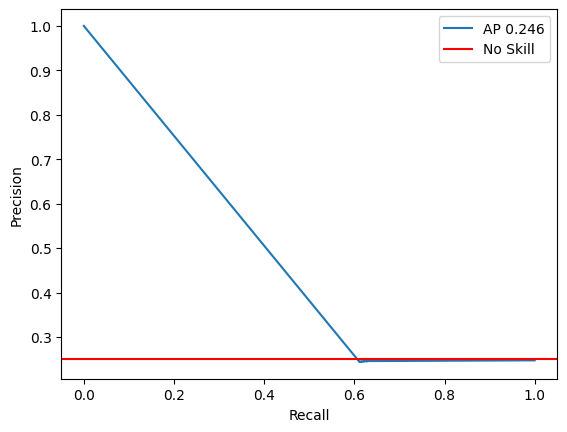

In [59]:
plt.plot(recall, precision, label='AP {}'.format(round(avg_precision, 3)))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axhline(y=0.25, color='r', linestyle='-',label='No Skill')# plt.ylim([0, 1.1])
plt.legend()
plt.show()